# NLP Mark Manson

In this repo I have scraped all of the articles on Mark Manson's website and performed analysis on it.   

The scrapers can be seen in [scrape_articles.py](scrape_articles.py).   

In [1]:
from common import *
import string
import re
import sys

import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime

import sqlite3
import numpy as np
import pandas as pd

import mywordcloud
import LatentDirichletAllocation

# $ pip install nltk
# $ python
# >> nltk.download('stopwords')
# >> nltk.download('punkt')
# >> nltk.download('wordnet')
# >> nltk.download('omw-1.4')
# >> nltk.download('averaged_perceptron_tagger')
# >> nltk.download('universal_tagset')
# quit()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


In [2]:
def get_file_text(filepath):
    '''
    This function joins all the lines into a single string and removes any newlines
    '''
    lines = []
    with open(filepath) as f:
        lines = f.readlines()
    return " ".join(lines).replace("\n", " ")

def clean_text(text):
    # lowercase the words
    lowercase_text = text.lower()
    
    # convert text into a list of words (tokens)
    word_tokens = word_tokenize(lowercase_text)
    
    # Remove Stop Words
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    stop_free_words = [w for w in word_tokens if w not in stop_words]

    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lammatized_words = [lemmatizer.lemmatize(w) for w in stop_free_words]

    # Stem the words
    # ps = PorterStemmer()
    # stemmed_words = [ps.stem(w) for w in lammatized_words]

    # remove the punctuation
    punc_list = set(string.punctuation)
    punc_free_words = [w for w in lammatized_words if w not in punc_list]
    alphanumeric_words = [w for w in punc_free_words if (w.isalnum())]

    return " ".join(alphanumeric_words)

In [3]:

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(DATABASE_NAME)
df = pd.read_sql_query("SELECT * from articles", con, index_col ="name")
con.close()

# Create Text Column
df["text"] = ""
df["tokens"] = ""
long_string_list = []
article_words_list = []
for i, row in df.iterrows():
    filepath = row["filepath"]
    text = get_file_text(filepath)
    cleaned_text = clean_text(text)
    row["text"] = cleaned_text
    
    word_tokens = word_tokenize(cleaned_text)
    row["tokens"] = word_tokens
    article_words_list.append(word_tokens)

    long_string_list.append(cleaned_text)

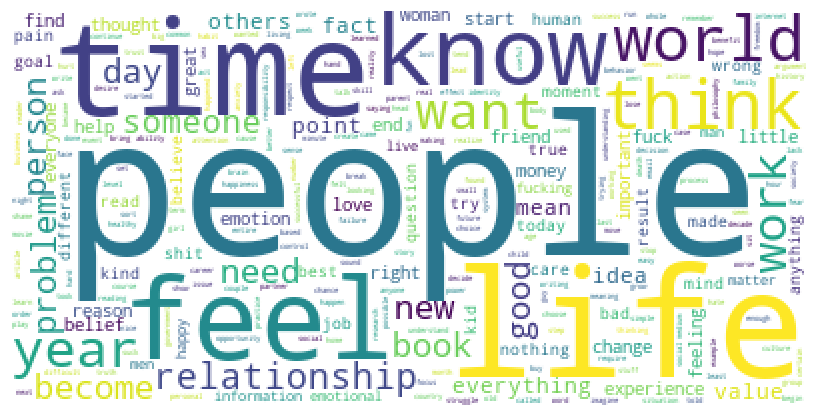

In [50]:

long_string = " ".join(long_string_list)
# remove_words = ["much", "got", "u", "take", "going", "yet", "lot", "may", "must", "thing", "likely", "could", "let", "able", "often", "well", "see", "give", "really", "way", "even", "every", "back", "one", "make", "still", "actually", "come", "something", "rather", "le", "two", "many", "put", "maybe", "say", "said", "far", "keep", "look", "call", "turn", "part", "either", "sometime", "pretty", "tell", "seem", "happen", "second", "first", "form", "around", "getting", "go", "might", "place", "another"]
# for rm in remove_words:
    # long_string = long_string.replace(" {} ".format(rm)," ")

token_words = long_string.split(" ")
pos_tags = nltk.pos_tag(token_words, tagset='universal')
cool_words = []
for i in range(len(token_words)):
    # print(pos_tags[i])
    if pos_tags[i][1] in ["NOUN", "VERB", "ADJ"]:
        cool_words.append(token_words[i])

long_string = " ".join(cool_words)
remove_words = ["much", "got", "u", "take", "going", "yet", "lot", "may", "must", "thing", "likely", "could", "let", "able", "often", "well", "see", "give", "really", "way", "even", "every", "back", "one", "make", "still", "actually", "come", "something", "rather", "le", "two", "many", "put", "maybe", "say", "said", "far", "keep", "look", "call", "turn", "part", "either", "sometime", "pretty", "tell", "seem", "happen", "second", "first", "form", "around", "getting", "go", "might", "place", "another", "sure"]
for rm in remove_words:
    long_string = long_string.replace(" {} ".format(rm)," ")


mywordcloud.create_word_cloud(long_string)


In [ ]:

# a = df.loc["interviewing-like-a-boss"]
# a_text = a["text"]
# print(a_text)
# print(article_words_list[0])
# sys.exit(0)


In [5]:

lda = LatentDirichletAllocation.LatentDirishletAllocation()

num_topics = 6
no_below = 25
no_above = 0.50
id2word_dictionary = lda.create_dictionary(article_words_list, no_below, no_above)
lda.create_bag_of_words_corpus()
# lda_model = lda.create_model(num_topics)
# lda.save_model()
lda_model = lda.load_model()
coherence = lda.get_coherence_score()


In [12]:

topics_data = {}
topicid_word_tuples = lda_model.show_topics(num_topics=num_topics, num_words=12, formatted=False)
for topicid_word_tuple in topicid_word_tuples:
    topic_id = topicid_word_tuple[0]
    topic_words_probability_tuples = topicid_word_tuple[1]
    words_string = " ".join([w[0] for w in topic_words_probability_tuples])
    print("{}: {}".format(topic_id, words_string))
    topics_data[topic_id] = {
        "topic_words_probability_tuples": topic_words_probability_tuples,
        "clean_words": words_string
    }

# After manually looking at the topics
topics_data[0]["Name"] = "World - News, Society, Culture"
topics_data[1]["Name"] = "Knowledge - Brain, Reading, Learning, Wisdom"
topics_data[2]["Name"] = "Sex and Dating Women"
topics_data[3]["Name"] = "Dealing with Bad Emotions"
topics_data[4]["Name"] = "Pursuit of Happiness"
topics_data[5]["Name"] = "Relationship Advice"


0: medium information news attention country health culture today internet read history society
1: belief read philosophy eye page brain trust understanding hope reading question identity
2: woman value men sex goal sexual man culture girl guy young definition
3: emotion shame step hour fucking felt week level stop habit night pain
4: emotion happiness meaning happy decision negative value pain brain control positive bias
5: partner job parent together dating respect question read word healthy yes behavior


In [13]:

df["topic_id"] = ""
for i, row in df.iterrows():
    article_word_tokens = row["tokens"]
    article_bag_of_words = id2word_dictionary.doc2bow(article_word_tokens)
    article_topic_distribution_tuples = lda_model.get_document_topics(article_bag_of_words, per_word_topics=False)
    
    # Get the TopicID that has the greatest probability
    max_tuple = max(article_topic_distribution_tuples, key=lambda x:x[1])
    max_topic_id = max_tuple[0]
    row["topic_id"] = max_topic_id
    
    # Add the file to that topic
    filepath = row["filepath"]
    if "articles" not in topics_data[max_topic_id]:
        topics_data[max_topic_id]["articles"] = []
    topics_data[max_topic_id]["articles"].append(i)


for key, value in topics_data.items():
    print("Topic: {} {}".format(key, value["clean_words"]))
    articles = value["articles"]
    for a in articles:
        print(" - {}".format(a))


Topic: 0 medium information news attention country health culture today internet read history society
 - trigger-warning
 - are-you-not-entertained
 - 3-principles-for-a-better-life
 - the-life-cycle-of-outrage
 - you-are-what-you-consume
 - benefits-of-time
 - social-media-isnt-the-problem
 - 4-ways-my-views-have-changed
 - favorite-books-2020
 - how-to-get-better
 - a-slow-moving-car-wreck
 - unintended-consequences
 - how-to-overcome-loneliness
 - logical-fallacies
 - the-best-and-the-worst-of-someone
 - chaos-and-uncertainty
 - the-dangers-of-distrust
 - why-you-should-quit-the-news
 - 10-important-lessons-from-the-2010s
 - three-months-later-does-the-attention-diet-work
 - the-death-of-tourism
 - principles-of-productivity
 - attention-diet
 - managing-your-mental-health
 - lifelong-learning
 - is-no-one-safe-from-the-bullshit
 - 5-books-that-explain-why-it-seems-the-world-is-so-fucked
 - 6-things-people-should-stop-giving-so-many-fucks-about
 - read-fiction
 - 3-simple-ideas
 - b

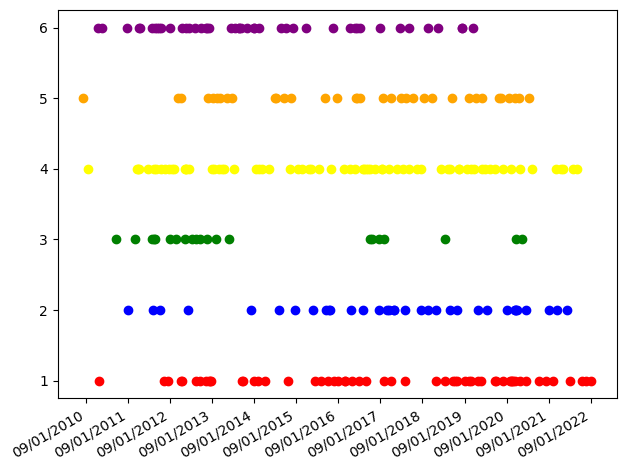

In [8]:

dates_strings = df["date"].to_numpy()
dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in dates_strings]

topic_ids = df["topic_id"].to_numpy() + 1
topic1_ids = (topic_ids == 1)*1
topic1_ids = np.array([id if id != False else None for id in topic1_ids])
topic2_ids = (topic_ids == 2)*2
topic2_ids = np.array([id if id != False else None for id in topic2_ids])
topic3_ids = (topic_ids == 3)*3
topic3_ids = np.array([id if id != False else None for id in topic3_ids])
topic4_ids = (topic_ids == 4)*4
topic4_ids = np.array([id if id != False else None for id in topic4_ids])
topic5_ids = (topic_ids == 5)*5
topic5_ids = np.array([id if id != False else None for id in topic5_ids])
topic6_ids = (topic_ids == 6)*6
topic6_ids = np.array([id if id != False else None for id in topic6_ids])
# print(np.sum(topic1_ids)+np.sum(topic2_ids)+np.sum(topic3_ids)+np.sum(topic4_ids)+np.sum(topic5_ids)+np.sum(topic6_ids))

# print(topic1_ids)
# print(len(topic1_ids))
# print(len(topic3_ids))
# print(len(dates))


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.scatter(dates,topic1_ids, color="red", label=topics_data[0]["Name"])
plt.scatter(dates,topic2_ids, color="blue", label=topics_data[1]["Name"])
plt.scatter(dates,topic3_ids, color="green", label=topics_data[2]["Name"])
plt.scatter(dates,topic4_ids, color="yellow", label=topics_data[3]["Name"])
plt.scatter(dates,topic5_ids, color="orange", label=topics_data[4]["Name"])
plt.scatter(dates,topic6_ids, color="purple", label=topics_data[5]["Name"])
# plt.set_xticks(x[::2])
# plt.set_xticklabels(x[::2], rotation=45)
# plt.xticks(np.arange(0, 300, 20.0))
plt.gcf().autofmt_xdate()
plt.tight_layout()
# plt.show()




# # initialize data of lists.
# data = {
#     1: topic1_ids*2,
#     2: topic2_ids*3,
#     3: topic3_ids*4,
#     4: topic4_ids*5,
#     5: topic5_ids*6,
#     6: topic6_ids*7,
# }

# # Creates pandas DataFrame.
# new_df = pd.DataFrame(data, index=dates_strings)

# sns.catplot(new_df)
# plt.show()